<a href="https://colab.research.google.com/github/NinaNikolova/data_mining_project/blob/main/python_games4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
r

#Linear regression модел за прогнозиране на потребителски рейтинг на видео игри използвайки само numeric features в dataset-a

In [22]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving video_game_reviews.csv to video_game_reviews (1).csv


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import re
import joblib
import warnings
warnings.filterwarnings('ignore')


In [24]:
df = pd.read_csv('/content/video_game_reviews.csv')
df.head()

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1


In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
User Rating,47774.0,29.719329,7.550131,10.10,24.30,29.700,35.1000,49.50
Price,47774.0,39.951371,11.520342,19.99,29.99,39.845,49.9575,59.99
Release Year,47774.0,2016.480952,4.027276,2010.00,2013.00,2016.000,2020.0000,2023.00
Game Length (Hours),47774.0,32.481672,15.872508,5.00,18.80,32.500,46.3000,60.00
Min Number of Players,47774.0,5.116758,2.769521,1.00,3.00,5.000,7.0000,10.00


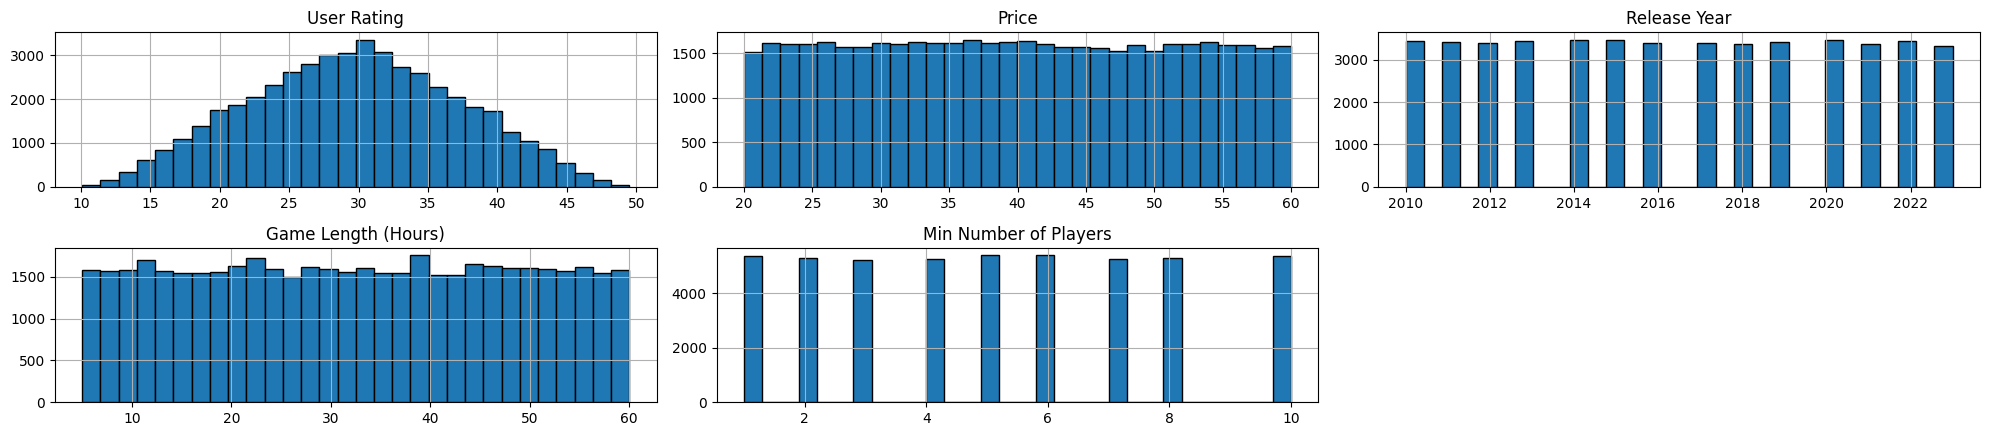

In [15]:
df.hist(figsize=(20, 15), bins=30, edgecolor='black', layout=(len(df.columns) // 3 + 1, 3))
plt.tight_layout()  # Prevent overlapping of subplots
plt.show()

In [16]:
print(df.select_dtypes(include='number').columns)

Index(['User Rating', 'Price', 'Release Year', 'Game Length (Hours)',
       'Min Number of Players'],
      dtype='object')


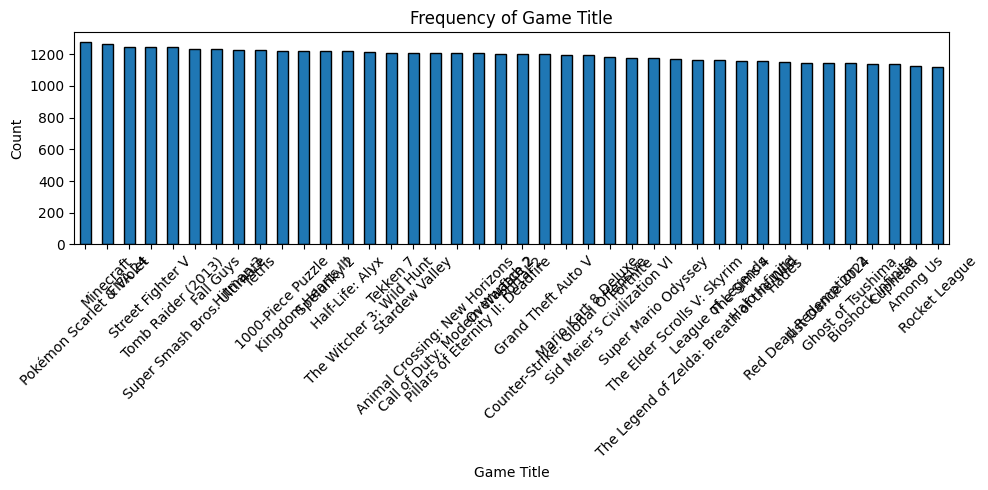

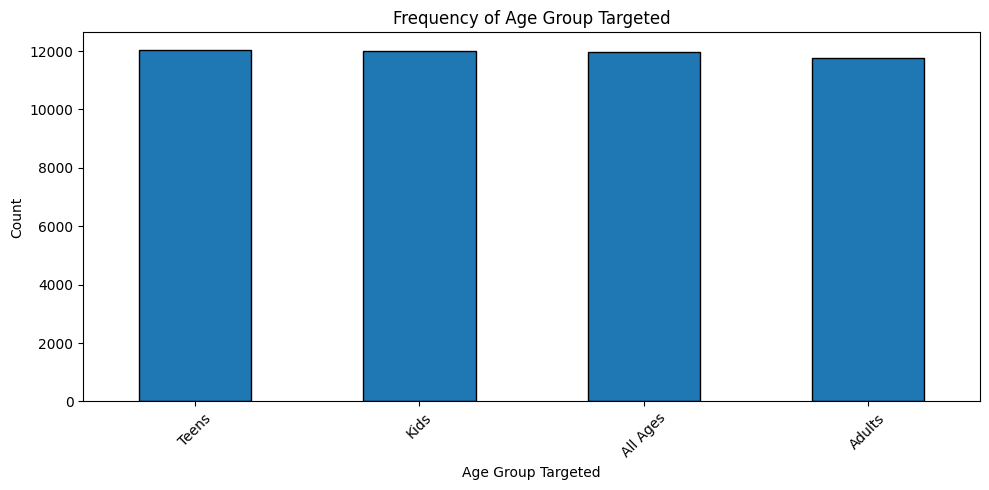

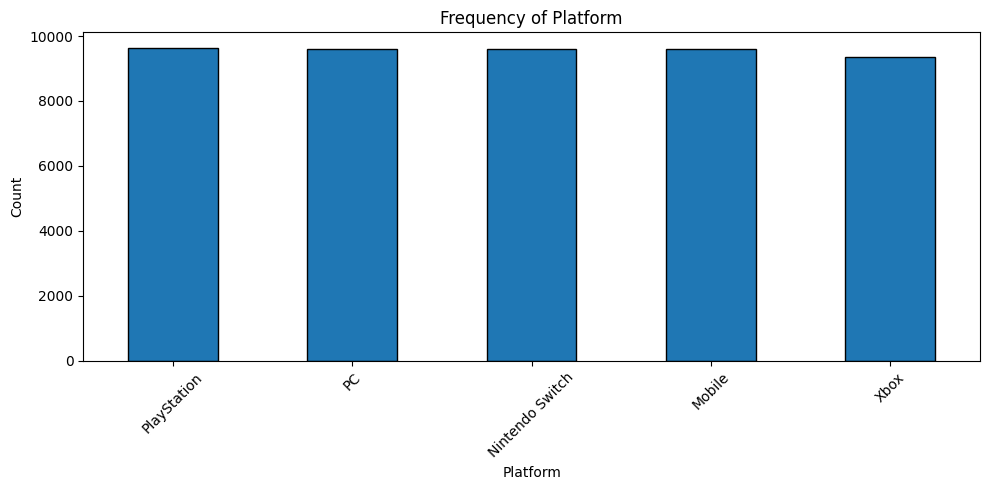

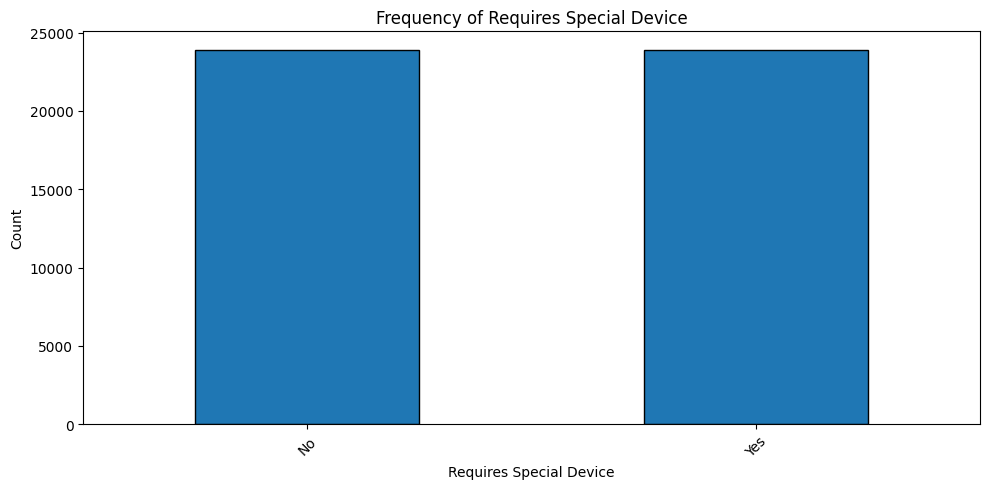

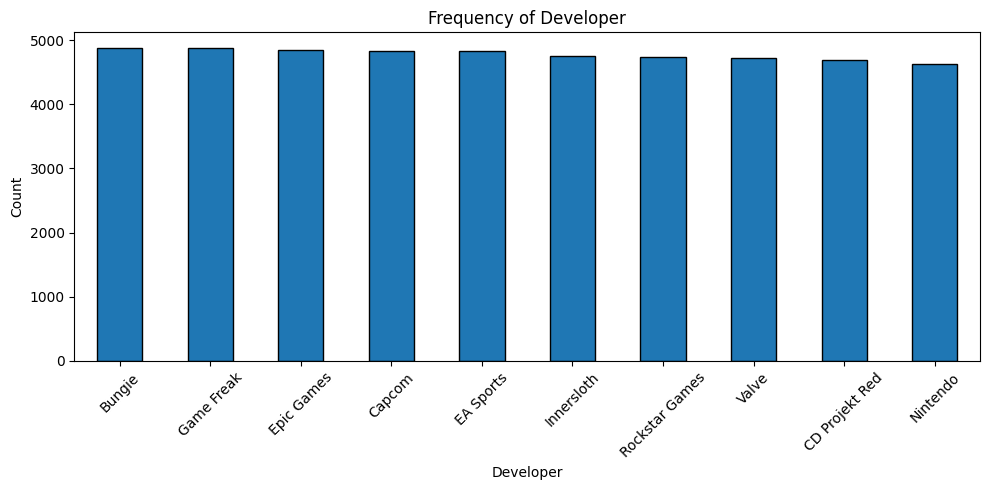

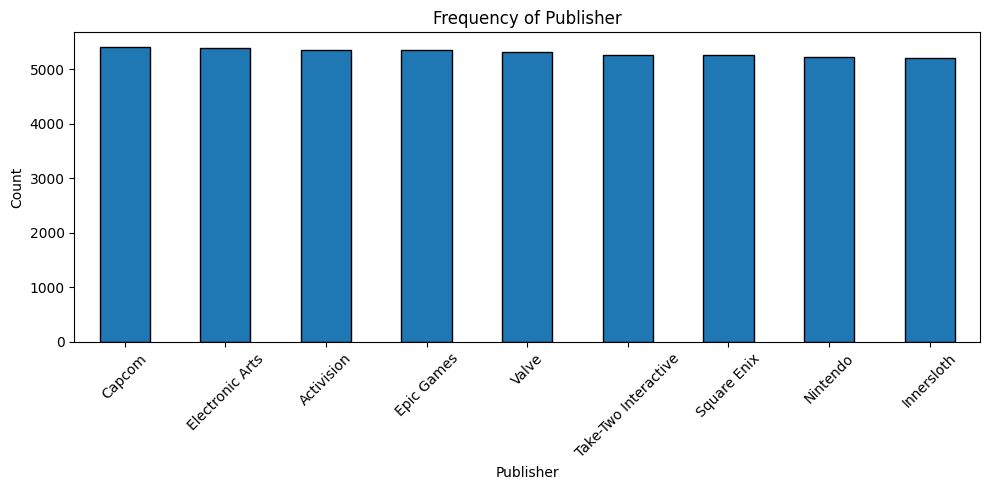

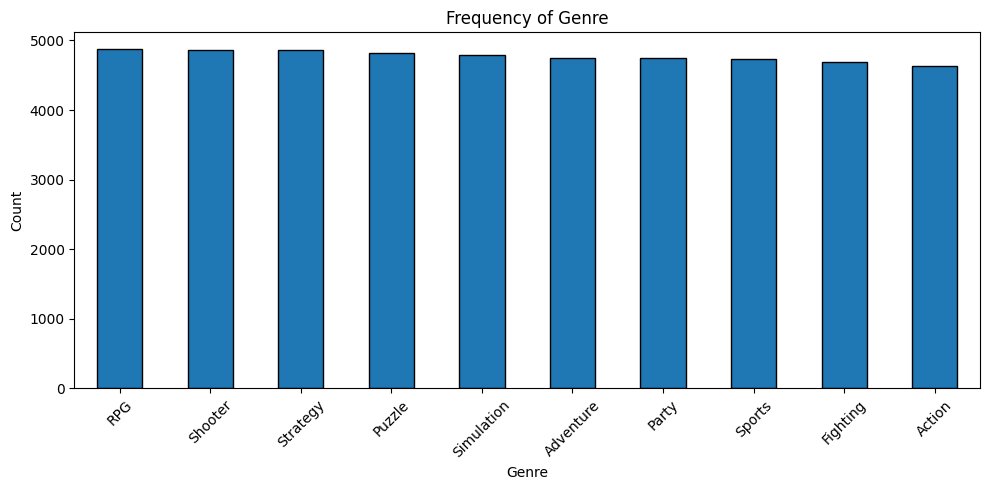

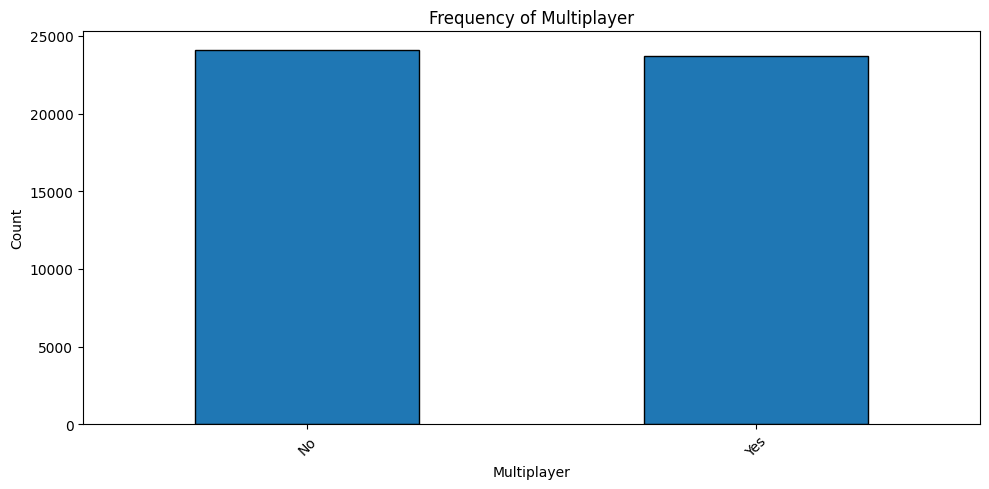

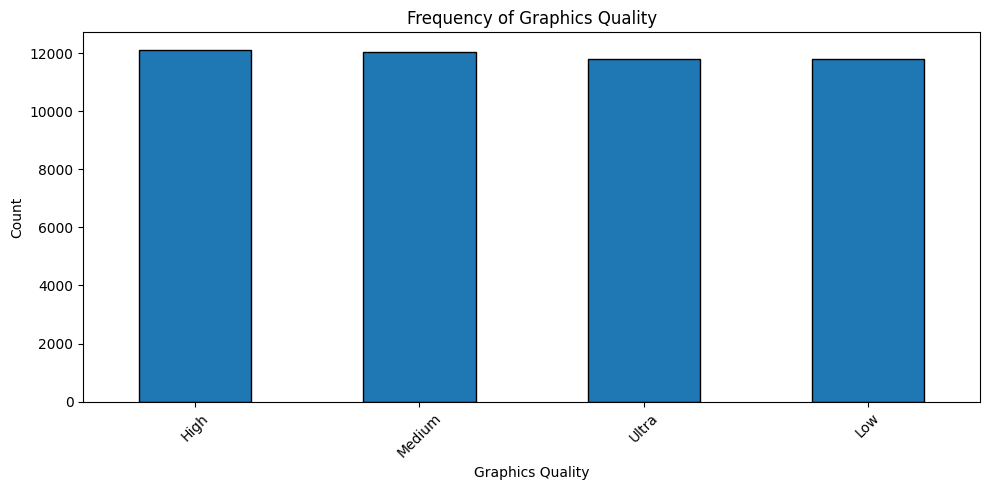

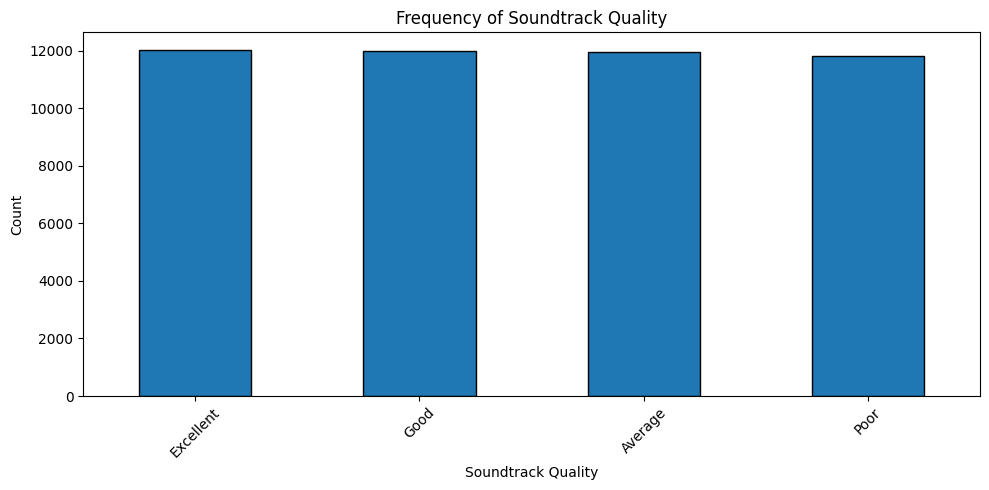

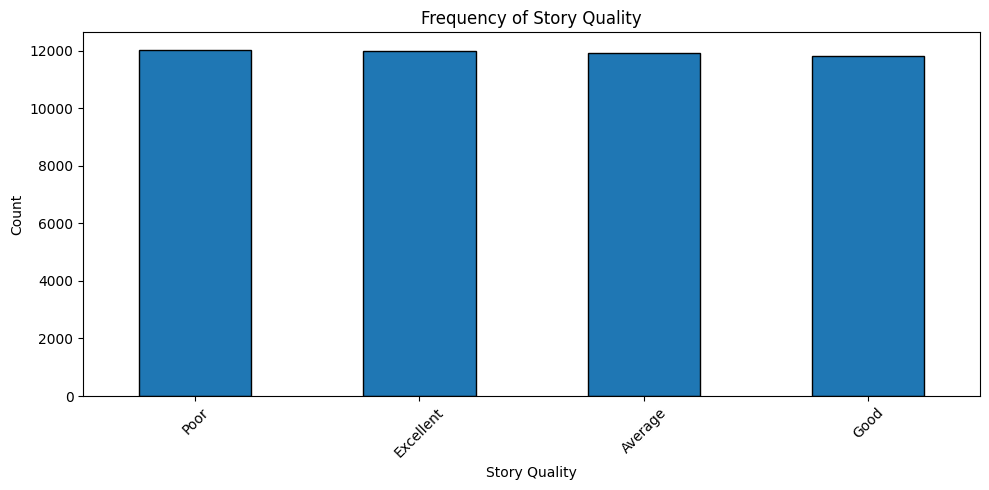

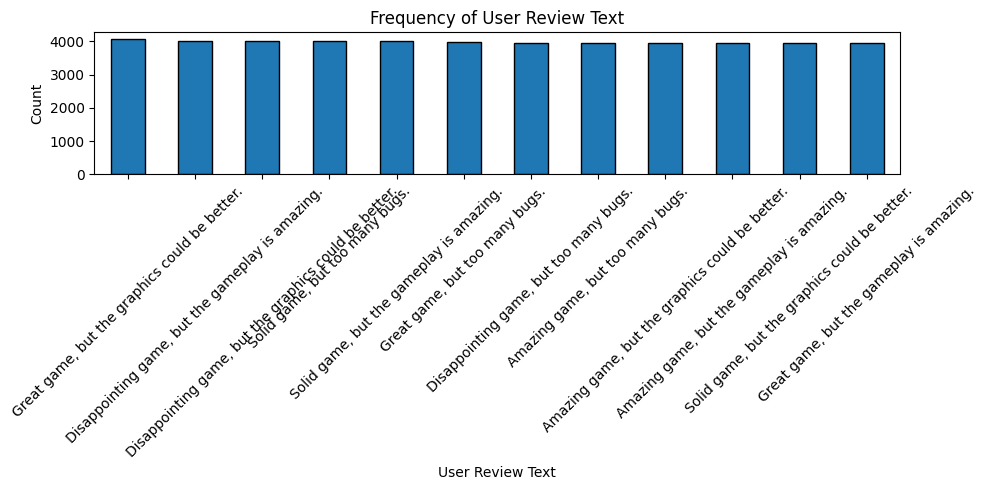

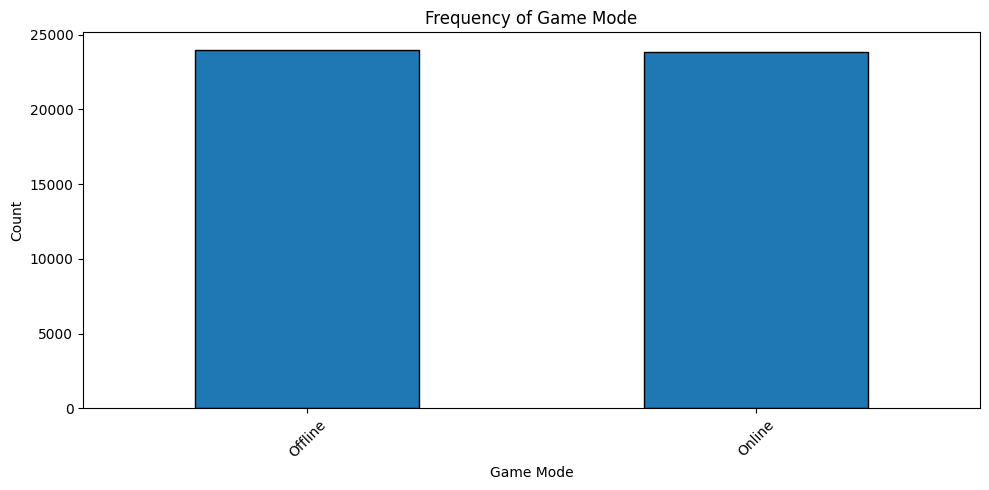

In [17]:
# Select categorical columns (object or category type)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Plot each one
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    df[col].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f'Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-labels if needed
    plt.tight_layout()
    plt.show()

## Select only numeric features

In [34]:
numeric_df = df.select_dtypes(include='number')  # Keep only numeric columns
numeric_df.head()

,User Rating,Price,Release Year,Game Length (Hours),Min Number of Players
0,36.4,41.41,2015,55.3,1
1,38.3,57.56,2015,34.6,3
2,26.8,44.93,2012,13.9,5
3,38.4,48.29,2015,41.9,4
4,30.1,55.49,2022,13.2,1


Define features (X) and target (y)
Choose your target variable (what you want to predict).
For example, suppose target_column is the name of your target:

In [35]:
X = numeric_df.drop(columns='User Rating')  # Features
y = numeric_df['User Rating']               # Target


Split into training and testing sets

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train a linear regression model

In [40]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Evaluate the model

In [41]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R² Score: 0.9769
Mean Squared Error: 1.3370


Show model coefficients

In [42]:
coefficients = pd.Series(model.coef_, index=X.columns)
print(coefficients.sort_values(ascending=False))

Price                    0.499734
Game Length (Hours)      0.299943
Min Number of Players    0.000791
Release Year            -0.001724
dtype: float64


Actual vs Predicted Scatter Plot

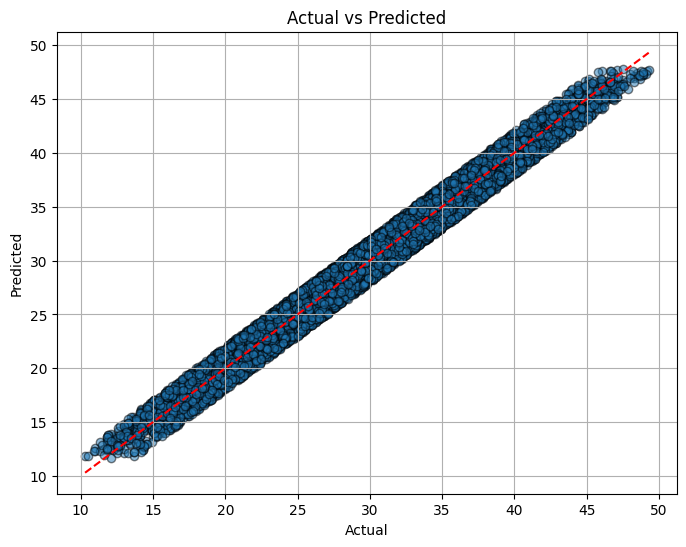

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()
